In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [9]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [20]:
# create engine to hawaii.sqlite
# Path to sqlite
database_path = "./Resources/hawaii.sqlite"

# Create an engine that can talk to the database
engine = create_engine(f"sqlite:///{database_path}", echo=False)

In [21]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [22]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [26]:
# Save references to each table
Measurement = Base.classes.measurement
Stations = Base.classes.station

In [24]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

In [234]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax for trip dates from a previous year
tripTemps = calc_temps('2017-08-01','2017-08-07')
tripTemps_df = pd.DataFrame(tripTemps,columns=(['min','ave','max']))

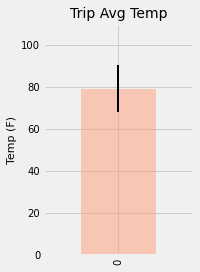

In [235]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
meanTemp = tripTemps_df['ave']
YERR = tripTemps_df['max'] - tripTemps_df['min']

meanTemp.plot(kind='bar',yerr=YERR,figsize=(3,4),ylim=(0,110),color='lightsalmon',alpha=.5,fontsize=10,error_kw=dict(lw=2))
plt.title("Trip Avg Temp",fontsize=14)
plt.ylabel("Temp (F)",fontsize=11)
plt.tight_layout()

### Daily Rainfall Average

In [236]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2017-08-01'
end_date = '2017-08-07'

stationData = session.query(Measurement.station, Stations.name,Stations.latitude,Stations.longitude,Stations.elevation, func.sum(Measurement.prcp)).\
    filter(Stations.station == Measurements.station).\
    filter(Measurements.date >= start_date).\
    filter(Measurements.date <= end_date).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurements.prcp).desc()).all()

pd.DataFrame(stationData,columns=(['StationID','Name','Lat','Lon','Elev','Rainfall']))


,StationID,Name,Lat,Lon,Elev,Rainfall
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.36
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.22
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.06
3,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.04
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.00


In [ ]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

In [239]:
# Create stripped date range from start-end
dateRange = pd.date_range(start=start_date,end=end_date).strftime("%m-%d")
fullDates = pd.date_range(start=start_date,end=end_date).date

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = []

for date in dateRange:
    results = daily_normals(date)[0]
    dateData = {"Date":date,
                "tmin":results[0],
                "tavg":results[1],
                "tmax":results[2]
               }
    normals.append(dateData)
    
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
tripData_df = pd.DataFrame(normals)
tripData_df['Date'] = fullDates
compData_df = tripData_df.set_index("Date")
compData_df

,tmin,tavg,tmax
Date,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


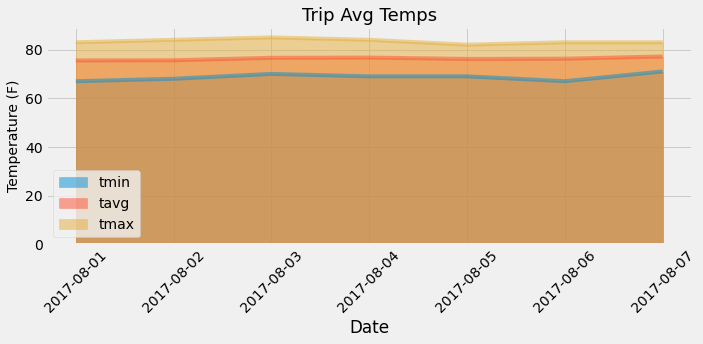

In [238]:
# Plot the daily normals as an area plot with `stacked=False`
compData_df.plot.area(figsize=(10,5),stacked=False,rot=45)
plt.title("Trip Avg Temps",fontsize=18)
plt.ylabel("Temperature (F)",fontsize=14)
plt.tight_layout()

## Close Session

In [240]:
# Close Session
session.close()